In [1]:
import numpy as np
import matplotlib.pyplot as plt

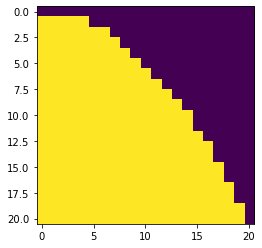

In [36]:
num_points = 21
x = np.linspace(0, 1, num_points)
y = np.linspace(0, 1, num_points)

def bool_domain_gen(x, y, num_points):
    x_g, y_g = np.meshgrid(x, np.sqrt(1-y))
    y_g = y_g[::-1]
    bool_domain = x_g < y_g
    return bool_domain

bool_domain = bool_domain_gen(x, y, num_points)

plt.figure(figsize = (4,4))
plt.imshow(bool_domain)

In [35]:
from math import floor

def iso_heat_solver_c_stencil(f, b1, b2, b3, M):
    h = 1/M

    x = np.linspace(0,1,M+1)
    y = np.linspace(0,1,M+1)
    P = (np.sqrt(1-y)//h).astype(int)
    print(P)

iso_heat_solver_c_stencil(1,1,1,1,20)

[19 19 18 18 17 17 16 16 15 14 14 13 12 11 10  9  8  7  6  4  0]
